In [1]:
%matplotlib notebook

from __future__ import division
import sys
import os
import csv
import sqlite3
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('.')
import scripts2d.utils as u
from wde.estimator import WaveletDensityEstimator


1000 (0, 2, 8, 0.13229401414141412)
2250 (0, 2, 8, 0.08129103853955369)
3500 (1, 2, 8, 0.06805449494949496)
4750 (0, 2, 8, 0.06234711313131306)
6000 (1, 2, 8, 0.058615308467741954)
7250 (0, 3, 8, 0.05441513967611334)
8500 (0, 3, 8, 0.04702252929292926)
9750 (1, 3, 8, 0.041643757142857084)
11000 (1, 3, 8, 0.037847313765182196)
J = 2 [(0, 1), (1, 0), (0, 0), (1, 1)]


<IPython.core.display.Javascript object>


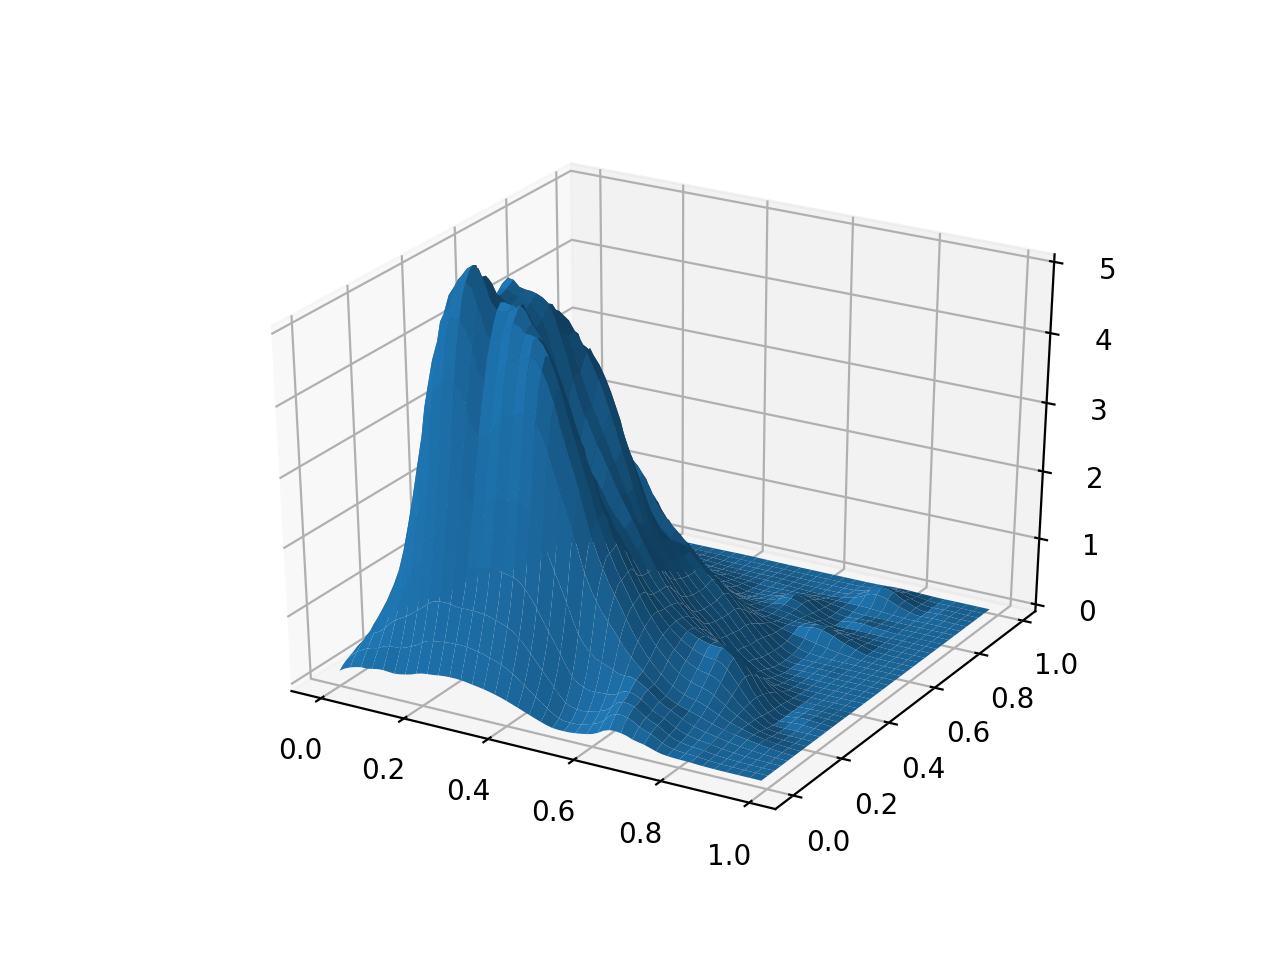

<IPython.core.display.Javascript object>


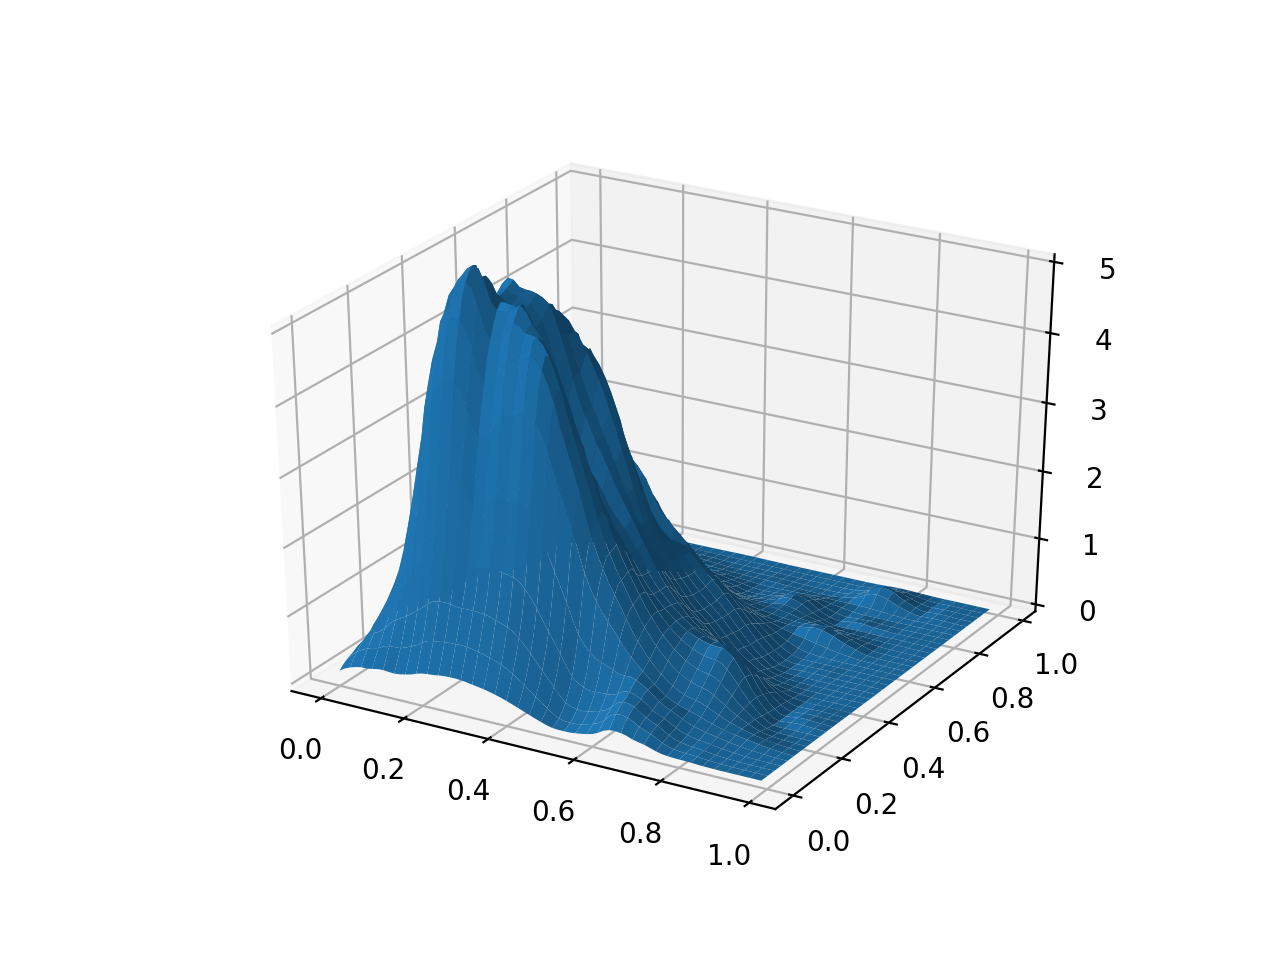

In [2]:
DBNAME = 'data/beta/db4/data.db'
CSVNAME = 'data/beta/db4/ise.csv'

def create_table(conn):
    sql = """
    CREATE TABLE IF NOT EXISTS results (
     fname varchar(256) NOT NULL,
     n integer NOT NULL,
     j0 integer NOT NULL,
     j1 integer NOT NULL,
     k integer NOT NULL,
     ise real NOT NULL,
     etime real NOT NULL
     )
    """
    conn.execute(sql)
    print 'results created'

def connect():
    if not os.path.isfile(DBNAME):
        conn = sqlite3.connect(DBNAME)
        create_table(conn)
    else:
        conn = sqlite3.connect(DBNAME)
    return conn

def read_rows(fcsv):
    for row in fcsv:
        if len(row) == 0 or len(row[0]) == 0:
            continue
        if len(row) != 9:
            continue
        try:
            yield row[0], int(row[3]), int(row[4]), int(row[5]), int(row[6]), float(row[7]), float(row[8])
        except:
            print 'E:',fcsv.line_num, len(row)

def load_data():
    with open(CSVNAME, 'r') as f:
        fcsv = csv.reader(f)
        with connect() as conn:
            conn.execute('delete from results')
            headers = next(fcsv)
            print headers
            for fname, n, j0, j1, k, ise, etime in read_rows(fcsv):
                try:
                    conn.execute('insert into results (fname, n, j0, j1, k, ise, etime) values (?,?,?,?,?,?,?)', (fname, n, j0, j1, k, ise, etime))
                except sqlite3.Error as e:
                    print e
                    print fname, n
                    raise
    print 'Done'

def exec_gen(conn, sql, args=()):
    cur = conn.execute(sql, args)
    row = cur.fetchone()
    while row is not None:
        yield row
        row = cur.fetchone()

def plot_n_vs_mise():
    data = []
    with connect() as conn:
        sql = "select n, min(ise) from results group by n"
        for row in exec_gen(conn, sql):
            data.append(row)
    data = np.array(data)
    plt.plot(data[:,0], data[:,1], 'b:')
    plt.title('Sample size vs MISE - Beta')
    plt.xlabel('n')
    plt.ylabel('MISE')
    plt.show()

def get_best_for_n():
    with connect() as conn:
        sql = "select n, j0, j1, k, avg(ise) as mise from results group by n, j0, j1, k"
        data = {}
        for row in exec_gen(conn, sql):
            n, j0, j1, k, mise = row
            if n not in data:
                data[n] = []
            data[n].append((j0, j1, k, mise))
        nn = data.keys()
        nn.sort()
        for n in nn:
            data[n].sort(key=(lambda tt: tt[3]))
            print n, data[n][0]

def get_best_params_for_n():
    data = {}
    with connect() as conn:
        sql = "select n, j0, j1, k, ise from results order by n, j0, j1, k"
        curparams = None
        curdata = []
        summary = []
        # calculate robust MISE from data for n, j0, j1, k
        for row in exec_gen(conn, sql):
            params = row[0:4]
            ise = row[4]
            if curparams == params:
                curdata.append(ise)
            else:
                if curparams is not None:
                    rmise = np.median(np.array(curdata))
                    summary.append((curparams, rmise))
                curdata = [ise]
                curparams = params
        if curparams is not None:
            rmise = np.median(np.array(curdata))
            summary.append((curparams, rmise))
        # now pick best j0, j1, k for each n
        min_rmise = {}
        curdata = []
        for params, rmise in summary:
            n, j0, j1, k = params
            if n in min_rmise:
                _, val = min_rmise[n]
                if rmise < val:
                    min_rmise[n] = ((j0, j1, k), rmise)
            else:
                min_rmise[n] = ((j0, j1, k), rmise)
        nn = min_rmise.keys()
        nn.sort()
        mises = []
        plt.figure()
        for n in nn:
            params, mise = min_rmise[n]
            #print n, '(j0,j1,k)=', params,'MISE=', mise
            mises.append(mise)
            plt.text(n if n<=4000 else n - 1350, mise + (0.006 if n<=4000 else -0.008), str(params))
        plt.scatter(nn, mises)
        plt.xlabel('n')
        plt.ylabel('MISE')
        plt.title('Best j0, j1, k per sample size (Bivariate Beta)')
        plt.show()

def average_after_best_per_sample():
    pass

def plot_it(dist):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(0., 1., 1/75)
    Y = np.arange(0., 1., 1/75)
    XX, YY = np.meshgrid(X, Y)
    Z = dist.pdf((XX, YY))
    surf = ax.plot_surface(XX, YY, Z, linewidth=0)
    ax.set_zlim(0, 5)
    plt.show()

def plot_beta_example(n):
    beta = u.dist_from_code('beta')
    data = beta.rvs(n)
    #plot_it(beta)
    wde = WaveletDensityEstimator('db4', k=8, j0=2, j1=2)
    wde.fit(data)
    plot_it(wde)
    wde = WaveletDensityEstimator('db4', k=8, j0=3, j1=None)
    wde.fit(data)
    plot_it(wde)
            
#get_best_params_for_n()
get_best_for_n()
#plot_n_vs_mise()
plot_beta_example(2250)